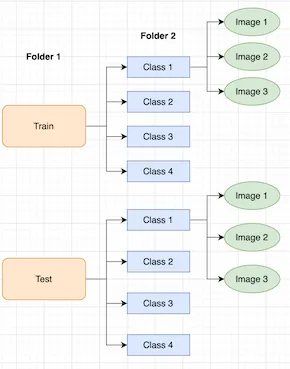

In [ ]:

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import numpy as np
import random


In [ ]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import glob
from tqdm import tqdm

In [ ]:
train_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RandomCrop(height=256, width=256),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)

In [ ]:
test_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.CenterCrop(height=256, width=256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [ ]:
train_data_path = 'images/train' 
test_data_path = 'images/test'

train_image_paths = [] #to store image paths in list
classes = [] #to store class values

In [ ]:
for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1]) 
    train_image_paths.append(glob.glob(data_path + '/*'))

In [ ]:
train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)


In [ ]:
print('train_image_path example: ', train_image_paths[0])
print('class example: ', classes[0])

In [ ]:
train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):] 

#3.
# create the test_image_paths
test_image_paths = []
for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

test_image_paths = list(flatten(test_image_paths))

print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))


In [ ]:
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class LandmarkDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        
        return image, label

In [ ]:
train_dataset = LandmarkDataset(train_image_paths,train_transforms)
valid_dataset = LandmarkDataset(valid_image_paths,test_transforms) #test transforms are applied
test_dataset = LandmarkDataset(test_image_paths,test_transforms)

In [ ]:
print('The shape of tensor for 50th image in train dataset: ',train_dataset[49][0].shape)
print('The label for 50th image in train dataset: ',train_dataset[49][1])

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def visualize_augmentations(dataset, idx=0, samples=10, cols=5, random_img = False):
    
    dataset = copy.deepcopy(dataset)
    #we remove the normalize and tensor conversion from our augmentation pipeline
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    
        
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1,len(train_image_paths))
        image, lab = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_class[lab])
    plt.tight_layout(pad=1)
    plt.show()    

visualize_augmentations(train_dataset,np.random.randint(1,len(train_image_paths)), random_img = True)


In [ ]:
from torch.utils.data import DataLoader

In [ ]:
train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True
)

valid_loader = DataLoader(
    valid_dataset, batch_size=64, shuffle=True
)


test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=False
)